In [1]:
import numpy as np
import math
import csv
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
COLORS=dict(zip(["burst", "utree", "centrifuge", "kraken", "bowtie2", 1, 2, 3, 4, 5], sns.color_palette("colorblind", 10)))
sns.palplot(sns.color_palette("colorblind", 10))

%matplotlib inline

In [2]:
def time_to_seconds(time):
    split_time = time.split(':')
    modifier = math.pow(60, len(split_time)-1)
    seconds = 0
    for time_part in split_time:
        seconds += (float(time_part) * modifier)
        modifier /= 60
    return seconds

def save_plot(pltname, artists=()):
    plt.savefig(os.path.join("..", "figures", "timing_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

In [3]:
files = glob.glob("../results/kraken_timing/**/timing.*.threads.*.txt")

rows = [('seconds_wall_clock', 'reads_per_minute', 'gbyte_memory', 'percent_cpu', 'cpu_hours', 'tool', 'threads', )]
for file_path in files:
    tool = file_path.split("/")[-2].split('_')[0]
    wall_clocks = []
    memories = []
    percent_cpus = []
    elapsed = []
    with open(file_path) as inf:
        for line in inf:
            line = line.strip()
            if 'Elapsed (wall clock)' in line:
                wall_clocks.append(time_to_seconds(line.split()[-1]))
            if 'Maximum resident set size' in line:
                memories.append(int(line.split()[-1])) 
            if 'Percent of CPU this job got' in line:
                percent_cpus.append(int(line.split()[-1][:-1]))
    if len(wall_clocks) > 0:
        threads = int(file_path.split("/")[-1].split('.')[-2])
        cpu_hours = (np.array(wall_clocks)/3600.)*(threads)
        m = np.argmin(cpu_hours)
        rows.append((wall_clocks[m], 3e7/(wall_clocks[m]/60.), memories[m]/1e6, percent_cpus[m], cpu_hours[m], tool, threads))

In [4]:
timing_df = pd.DataFrame(rows[1:], columns=rows[0])

In [5]:
timing_df.head()
timing_df.to_csv("../figures/timing_table.txt", sep="\t")

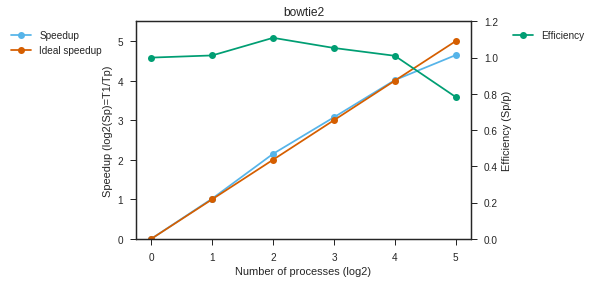

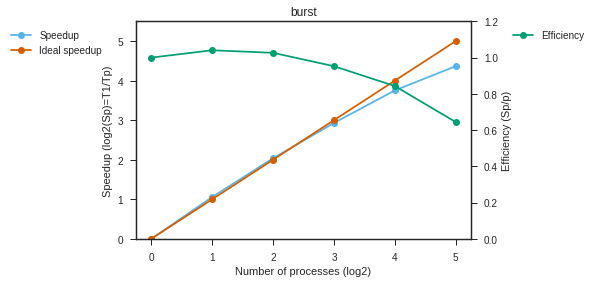

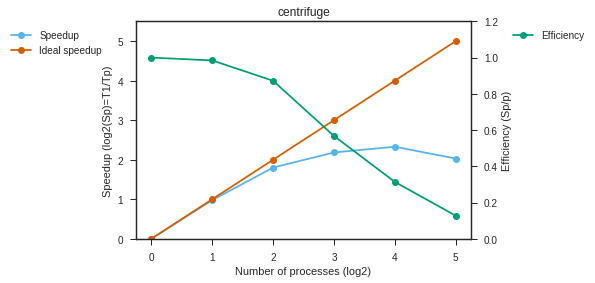

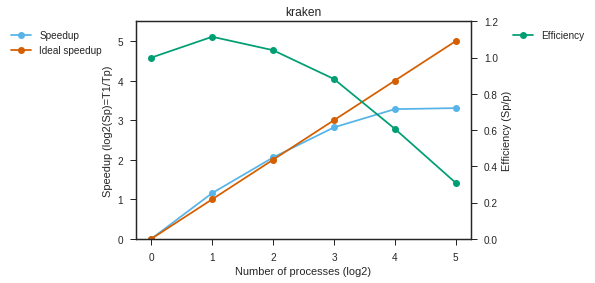

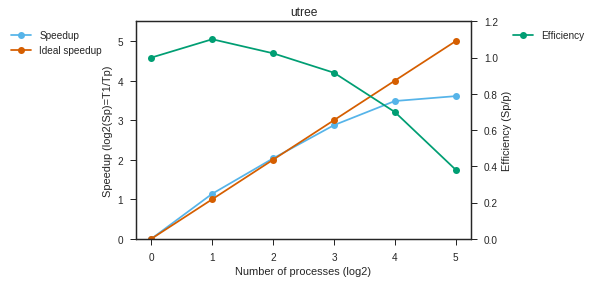

In [6]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: speedup T(1)/T(N), efficiency (T(1)/T(N))/N
# x-axis: N (workers)
for group, df_group in timing_df.groupby("tool"):
    # grouped by tool
    # group now by threads and get mean
    df_threads = df_group.groupby("threads").mean()


    # Mean time for 1 thread
    T_1 = df_threads.loc[1, "seconds_wall_clock"]

    speedup = T_1/df_threads["seconds_wall_clock"]
    efficiency = speedup/df_threads.index


    fig, ax1 = plt.subplots()
    t = np.arange(0.01, 10.0, 0.01)
    s1 = np.exp(t)

    ax1.plot(np.log2(df_threads.index), np.log2(speedup), c=COLORS[1], marker='o', label="Speedup")
    ax1.plot(np.log2(df_threads.index), np.log2(df_threads.index), c=COLORS[4], marker='o', label="Ideal speedup")

    ax1.set_xlabel('Number of processes (log2)')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Speedup (log2(Sp)=T1/Tp)')
    ax1.tick_params('y')

    ax2 = ax1.twinx()
    s2 = np.sin(2 * np.pi * t)
    ax2.plot(np.log2(df_threads.index), efficiency, c=COLORS[3], marker='o', label="Efficiency")
    ax2.set_ylabel('Efficiency (Sp/p)')
    ax2.tick_params('y')
    ax2.grid(False)
    ax1.set_ylim(0,5.5)
    ax2.set_ylim(0,1.2)
    lgd1 = ax1.legend(loc=2, bbox_to_anchor=(-.4, 1.))
    lgd2 = ax2.legend(loc=2, bbox_to_anchor=(1.1, 1.))
    plt.title(group)
    pltname = "%s_speedup_efficiency" % group
    save_plot(pltname, artists=(lgd1,lgd2,))

In [7]:
# 10276592        ./centrifuge_rep82
# 142765472       ./kraken_rep82
# 160638208       ./burst
# 8099232        ./utree
# 42931344        ./bt2

aligners = ["utree", "centrifuge", "bowtie2", "burst", "kraken"]
database_gbytes = [8099232/1e6, 10276592/1e6, 42931344/1e6, 160638208/1e6, 142765472/1e6]

#9235008 ./combined_seqs.fna
infile_gbytes = 9235008/1e6

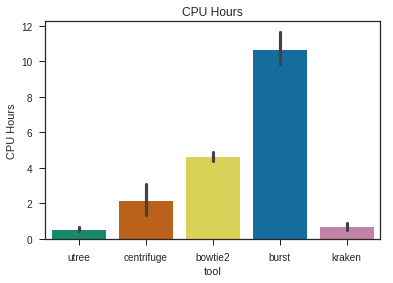

In [8]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: CPU Hours
# x-axis: N (workers)

ax = sns.barplot(x="tool", y="cpu_hours", data=timing_df, palette=COLORS)

plt.title("CPU Hours")
pltname = "cpu_hours_bar"
plt.ylabel("CPU Hours")
save_plot(pltname)

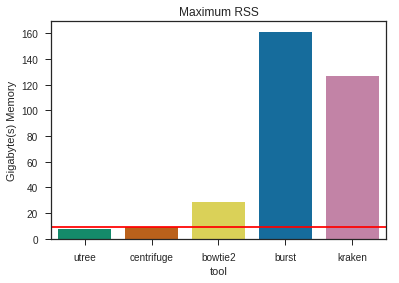

In [9]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: RAM Usage
# x-axis: N (workers)

ax = sns.barplot(x="tool", y="gbyte_memory", data=timing_df, palette=COLORS)

plt.plot(np.linspace(-100,100,2), [infile_gbytes]*2, 'r', label='input file size')

plt.title("Maximum RSS")
pltname = "ram_bar"
plt.ylabel("Gigabyte(s) Memory")
save_plot(pltname)

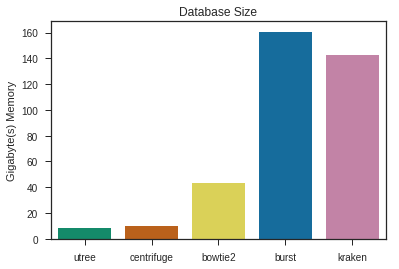

In [10]:
ax = sns.barplot(x=aligners, y=database_gbytes, palette=COLORS)
plt.title("Database Size")
pltname = "database_bar"
plt.ylabel("Gigabyte(s) Memory")
save_plot(pltname)

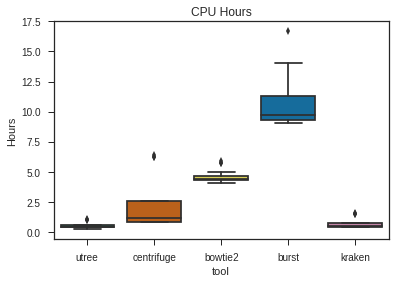

In [11]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: CPU Hours
# x-axis: N (workers)

ax = sns.boxplot(x="tool", y="cpu_hours", data=timing_df, palette=COLORS)

plt.title("CPU Hours")
pltname = "cpu_hours_box"
plt.ylabel("Hours")
save_plot(pltname)

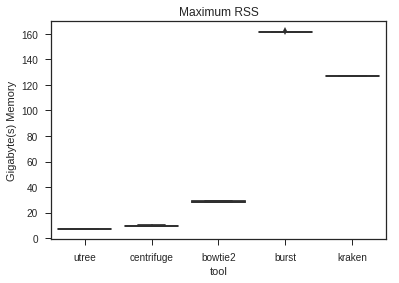

In [12]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: RAM Usage
# x-axis: N (workers)

ax = sns.boxplot(x="tool", y="gbyte_memory", data=timing_df, palette=COLORS)

plt.title("Maximum RSS")
plt.ylabel("Gigabyte(s) Memory")
pltname = "ram_boxplot"
save_plot(pltname)

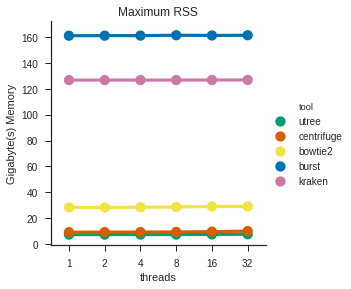

In [13]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: Reads per Minute
# x-axis: N (workers)

ax = sns.factorplot(x="threads", y="gbyte_memory", hue="tool", data=timing_df, palette=COLORS)

plt.title("Maximum RSS")
plt.ylabel("Gigabyte(s) Memory")
pltname = "ram_per_thread"
save_plot(pltname)

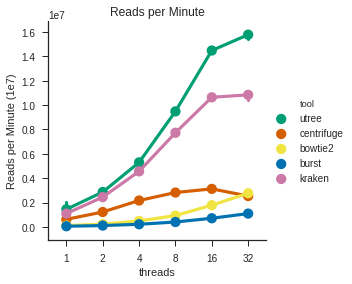

In [14]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: Reads per Minute
# x-axis: N (workers)

ax = sns.factorplot(x="threads", y="reads_per_minute", hue="tool", data=timing_df, palette=COLORS)

plt.title("Reads per Minute")
plt.ylabel("Reads per Minute (1e7)")
pltname = "reads_per_minute"
save_plot(pltname)

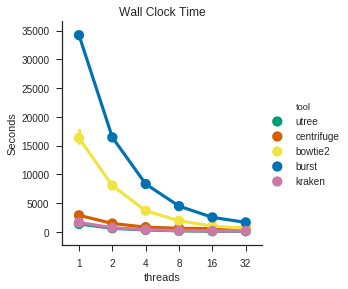

In [15]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: Reads per Minute
# x-axis: N (workers)

ax = sns.factorplot(x="threads", y="seconds_wall_clock", hue="tool", data=timing_df, palette=COLORS)

plt.title("Wall Clock Time")
plt.ylabel("Seconds")
pltname = "factor_wall_clock"
save_plot(pltname)

In [16]:
## Read statistics
files = glob.glob("../data/kraken_timing/*_timing.fa")

file_stats = []
for i, file in enumerate(files):
    file_stats.append([0, 0, os.path.basename(file)[:-3]])
    with open(file) as inf:
        for line in inf:
            if line.startswith(">"):
                file_stats[i][0] += 1
            else:
                file_stats[i][1] += len(line.strip())

In [17]:
file_stats

[[10000000, 923236223, 'HiSeq_timing'],
 [10000000, 1568044727, 'MiSeq_timing'],
 [10000000, 1000000000, 'simBA5_timing']]

In [18]:
df_files = pd.DataFrame(file_stats, columns=["num_reads", "bps", "filename"])
df_files["bases_per_read"] = df_files["bps"]/df_files["num_reads"]
df_files.to_csv("../figures/timing_timing_reads_stats.txt", sep="\t")
df_files

,num_reads,bps,filename,bases_per_read
0,10000000,923236223,HiSeq_timing,92.323622
1,10000000,1568044727,MiSeq_timing,156.804473
2,10000000,1000000000,simBA5_timing,100.000000


In [19]:
megabases = df_files["bps"].sum()/1e6
print(megabases)

3491.28095
